In [25]:
%load_ext autoreload
%autoreload 2

In [26]:

import pprint
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from backtest import backtest
from downloader import Downloader
from njit_funcs import *
from plotting import plot_fills
from procedures import dump_live_config, prepare_backtest_config, make_get_filepath
from pure_funcs import numpyize, analyze_fills, round_values

In [27]:
plt.rcParams['figure.figsize'] = [29, 18]
pd.set_option('precision', 10)

In [28]:
class Args:
    def __init__(self):
        self.backtest_config_path = 'configs/backtest/default.hjson'
        self.exchange = 'binance'
        self.symbol = 'XLMUSDT'
        self.market_type = 'futures'
        self.user = 'binance_01'
        self.start_date = '2021-10-01'
        self.end_date = '2022-01-15'
        self.starting_balance = 20.0
        self.starting_configs = ''
        self.base_dir = 'backtests'
config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
data = await dl.get_sampled_ticks()
timestamps = data[:, 0]
qtys = data[:, 1]
prices = data[:, 2]
config['n_days'] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f'millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms')

fetching market_specific_settings...
linear perpetual
2022-01-16T04:33:27  Loading cached tick data from backtests\binance\XLMUSDT\caches\2021-10-01_2022-01-15_ticks_cache.npy 
millis to load 9158400 ticks 106ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

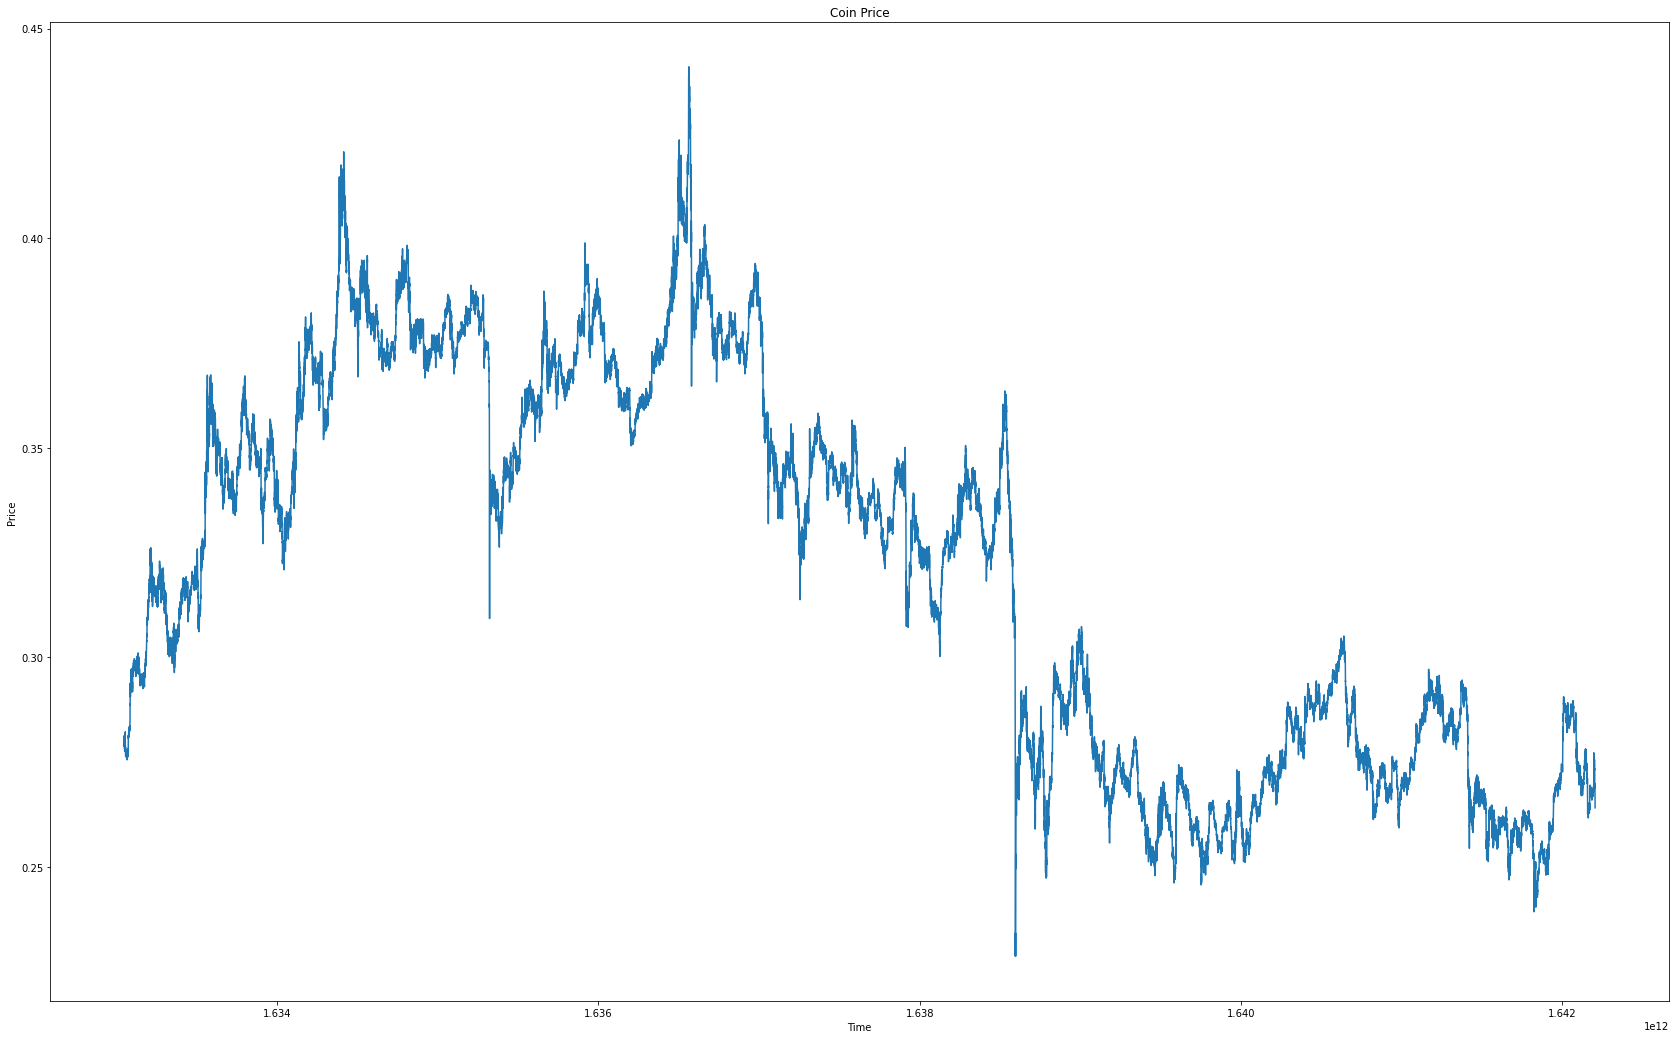

In [29]:
df = pd.DataFrame({'timestamp': timestamps, 'qty': qtys, 'price': prices}).set_index('timestamp')
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [30]:
# choose a slice on which to test
wsize_days = 240
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [42]:
hand_tuned = {
    "config_name": "hand_tuned",
    "logging_level": 0,
    "long": {
        "enabled": True,
        "eprice_exp_base": 1.618034,
        "eprice_pprice_diff": 0.003658892939380253,
        "grid_span": 0.22853784011628792,
        "initial_qty_pct": 0.05408197877923299,
        "markup_range": 0.006059163579862789,
        "max_n_entry_orders": 10,
        "min_markup": 0.004995326491543503,
        "n_close_orders": 7,
        "pbr_limit": 0.2,
        "secondary_pbr_allocation": 0.5,
        "secondary_pprice_diff": 0.39766077007512185
    },
    "shrt": {
        "enabled": False,
        "eprice_exp_base": 1.618034,
        "eprice_pprice_diff": 0.001,
        "grid_span": 0.03,
        "initial_qty_pct": 0.001,
        "markup_range": 0.004,
        "max_n_entry_orders": 10,
        "min_markup": 0.0005,
        "n_close_orders": 7,
        "pbr_limit": 0.5,
        "secondary_pbr_allocation": 0,
        "secondary_pprice_diff": 0.21
    }
}

# round for better human readability
hand_tuned = round_values(hand_tuned, 4)
config['starting_balance'] = 50.0
config['latency_simulation_ms'] = 1000
config_to_test = {**config, **numpyize(hand_tuned)}
dump_live_config(config_to_test, make_get_filepath(f'tmp/hand_tuned.json'))
hand_tuned

{'config_name': 'hand_tuned',
 'logging_level': 0,
 'long': {'enabled': True,
  'eprice_exp_base': 1.618,
  'eprice_pprice_diff': 0.003659,
  'grid_span': 0.2285,
  'initial_qty_pct': 0.05408,
  'markup_range': 0.006059,
  'max_n_entry_orders': 10,
  'min_markup': 0.004995,
  'n_close_orders': 7,
  'pbr_limit': 0.2,
  'secondary_pbr_allocation': 0.5,
  'secondary_pprice_diff': 0.3977},
 'shrt': {'enabled': False,
  'eprice_exp_base': 1.618,
  'eprice_pprice_diff': 0.001,
  'grid_span': 0.03,
  'initial_qty_pct': 0.001,
  'markup_range': 0.004,
  'max_n_entry_orders': 10,
  'min_markup': 0.0005,
  'n_close_orders': 7,
  'pbr_limit': 0.5,
  'secondary_pbr_allocation': 0,
  'secondary_pprice_diff': 0.21}}

In [43]:
sts = time()
fills, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f'seconds elapsed {elapsed:.4f}')
fdf, sdf, analysis = analyze_fills(fills, stats, config_to_test)
pprint.pprint(analysis)
fdf

seconds elapsed 3.5920
{'adjusted_daily_gain': 0.00034873834916001917,
 'average_daily_gain': 0.000348744004393442,
 'avg_fills_per_day': 1.5094438511782704,
 'biggest_psize': 31.0,
 'closest_bkr': 1.0,
 'eqbal_ratio_mean': 0.9773777829307152,
 'eqbal_ratio_median': 0.9770817739902269,
 'eqbal_ratio_min': 0.9345369933866018,
 'exchange': 'binance',
 'fee_sum': -0.16602507600000002,
 'final_balance': 51.882584923999964,
 'final_equity': 49.70790492399996,
 'gain': 0.037651698479999274,
 'hrs_stuck_avg': 1271.9916666666666,
 'hrs_stuck_avg_long': 211.9986111111111,
 'hrs_stuck_avg_shrt': 1271.9916666666666,
 'hrs_stuck_max': 2543.983333333333,
 'hrs_stuck_max_long': 1169.1033333333332,
 'hrs_stuck_max_shrt': 2543.983333333333,
 'loss_sum': 0.0,
 'n_closes': 79,
 'n_days': 105.99930555555555,
 'n_entries': 81,
 'n_fills': 160,
 'n_ientries': 80,
 'n_rentries': 1,
 'net_pnl_plus_fees': 1.8825849239999992,
 'pa_closeness_max_long': 0.6457364052555178,
 'pa_closeness_max_shrt': 100.0,
 'pa_c

,trade_id,timestamp,pnl,fee_paid,balance,equity,qty,price,psize,pprice,type,pbr
0,4,1633046404000.0,0.00000,-0.001003932,49.998996068,49.998636068,18.0,0.27887,18.0,0.2788700000,long_ientry,0.1003952158
1,365,1633046765000.0,0.02520,-0.001008972,50.023187096,50.023187096,-18.0,0.28027,0.0,0.2788700000,long_nclose,0.0000000000
2,366,1633046766000.0,0.00000,-0.001009944,50.022177152,50.021277152,18.0,0.28054,18.0,0.2805400000,long_ientry,0.1009496245
3,7768,1633054168000.0,0.02538,-0.001015020,50.046542132,50.046542132,-18.0,0.28195,0.0,0.2805400000,long_nclose,0.0000000000
4,7772,1633054172000.0,0.00000,-0.001018476,50.045523656,50.044803656,18.0,0.28291,18.0,0.2829100000,long_ientry,0.1017549548
...,...,...,...,...,...,...,...,...,...,...,...,...
155,3516402,1636562802000.0,0.02628,-0.001055424,51.860374406,51.860374406,-12.0,0.43976,0.0,0.4375700000,long_nclose,0.0000000000
156,3516403,1636562803000.0,0.00000,-0.001055520,51.859318886,51.858718886,12.0,0.43980,12.0,0.4398000000,long_ientry,0.1017676305
157,3516476,1636562876000.0,0.02640,-0.001060800,51.884658086,51.884658086,-12.0,0.44200,0.0,0.4398000000,long_nclose,0.0000000000
158,3516478,1636562878000.0,0.00000,-0.001061184,51.883596902,51.881316902,12.0,0.44216,12.0,0.4421600000,long_ientry,0.1022658473


In [44]:
sdf

,timestamp,balance,equity,bkr_price,long_psize,long_pprice,shrt_psize,shrt_pprice,price,closest_bkr,long_pbr,shrt_pbr
0,1633046402000.0,50.000000000,50.000000000,0.0,0.0,0.0000000000,0.0,0.0,0.27885,1.0,0.0000000000,0.0
1,1633046462000.0,49.998996068,49.999896068,0.0,18.0,0.2788700000,0.0,0.0,0.27892,1.0,0.1003952158,0.0
2,1633046522000.0,49.998996068,49.999536068,0.0,18.0,0.2788700000,0.0,0.0,0.27890,1.0,0.1003952158,0.0
3,1633046582000.0,49.998996068,50.009076068,0.0,18.0,0.2788700000,0.0,0.0,0.27943,1.0,0.1003952158,0.0
4,1633046642000.0,49.998996068,50.017896068,0.0,18.0,0.2788700000,0.0,0.0,0.27992,1.0,0.1003952158,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
150739,1642204502000.0,51.882584924,49.750374924,0.0,31.0,0.3343809677,0.0,0.0,0.26560,1.0,0.1997936305,0.0
150740,1642204562000.0,51.882584924,49.735184924,0.0,31.0,0.3343809677,0.0,0.0,0.26511,1.0,0.1997936305,0.0
150741,1642204622000.0,51.882584924,49.713174924,0.0,31.0,0.3343809677,0.0,0.0,0.26440,1.0,0.1997936305,0.0
150742,1642204682000.0,51.882584924,49.707284924,0.0,31.0,0.3343809677,0.0,0.0,0.26421,1.0,0.1997936305,0.0


<AxesSubplot:title={'center':'Balance and equity'}, xlabel='Time', ylabel='Balance'>

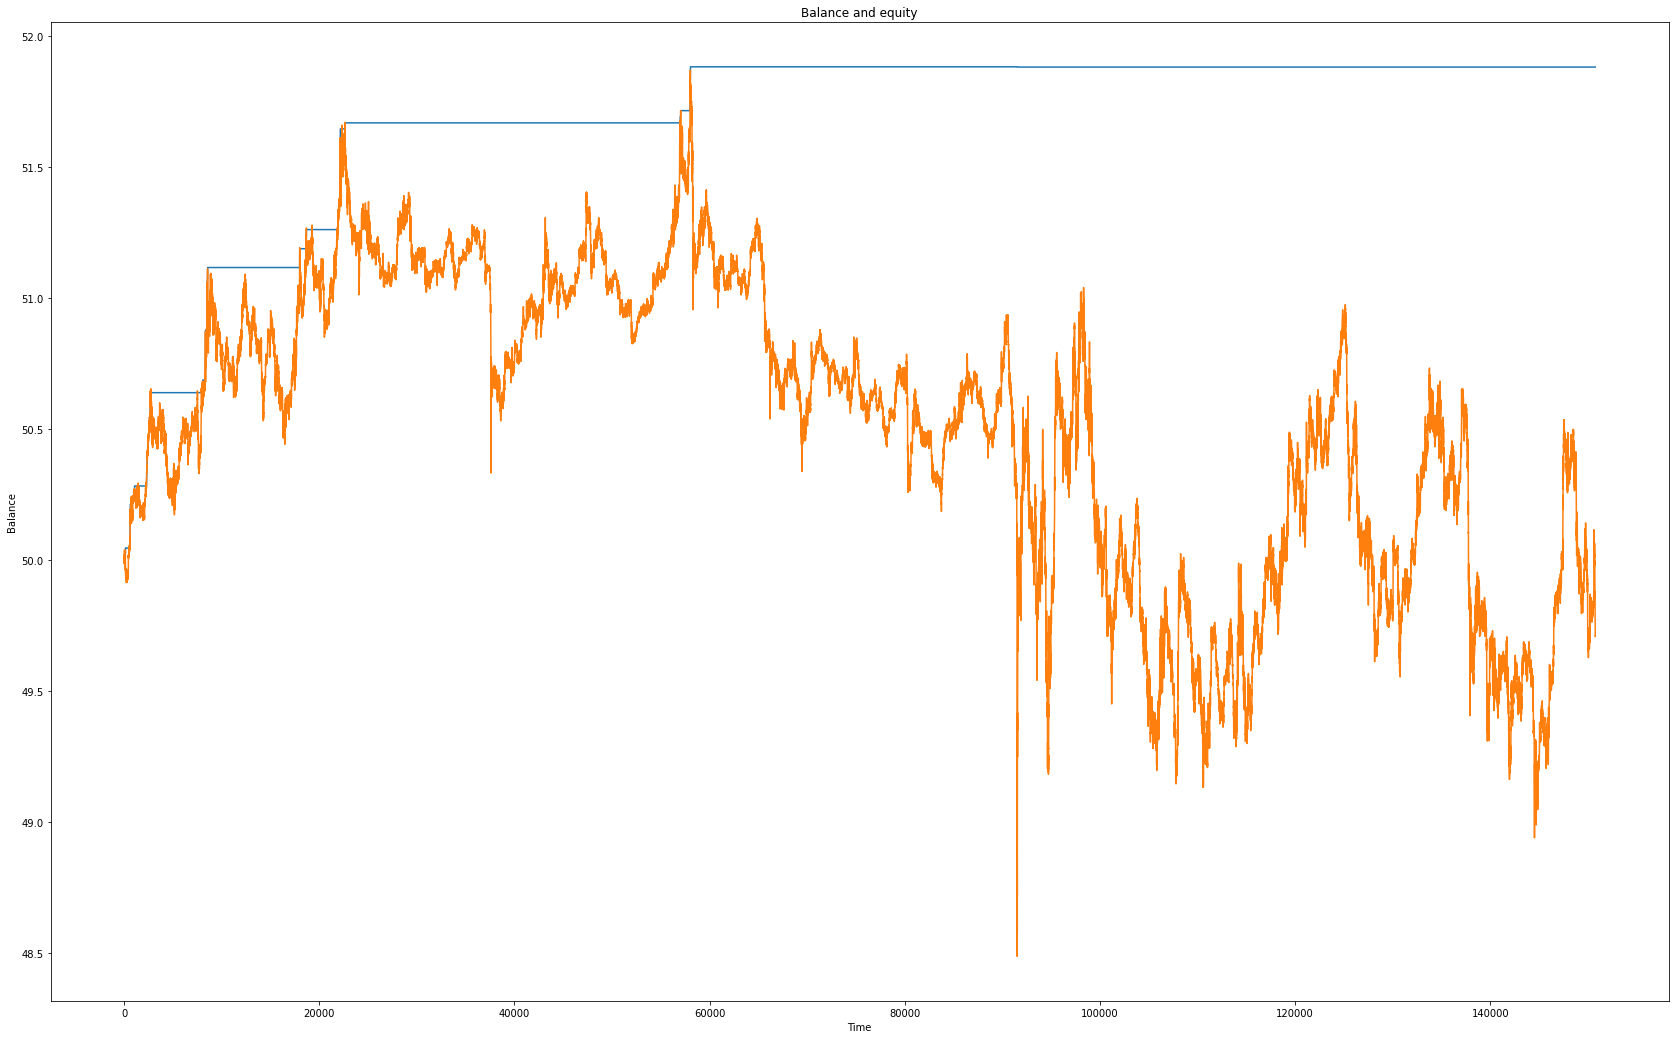

In [45]:
sdf.balance.plot()
sdf.equity.plot(title="Balance and equity", xlabel="Time", ylabel="Balance")

<module 'matplotlib.pyplot' from 'C:\\Users\\skhan\\anaconda3\\envs\\passivbot\\lib\\site-packages\\matplotlib\\pyplot.py'>

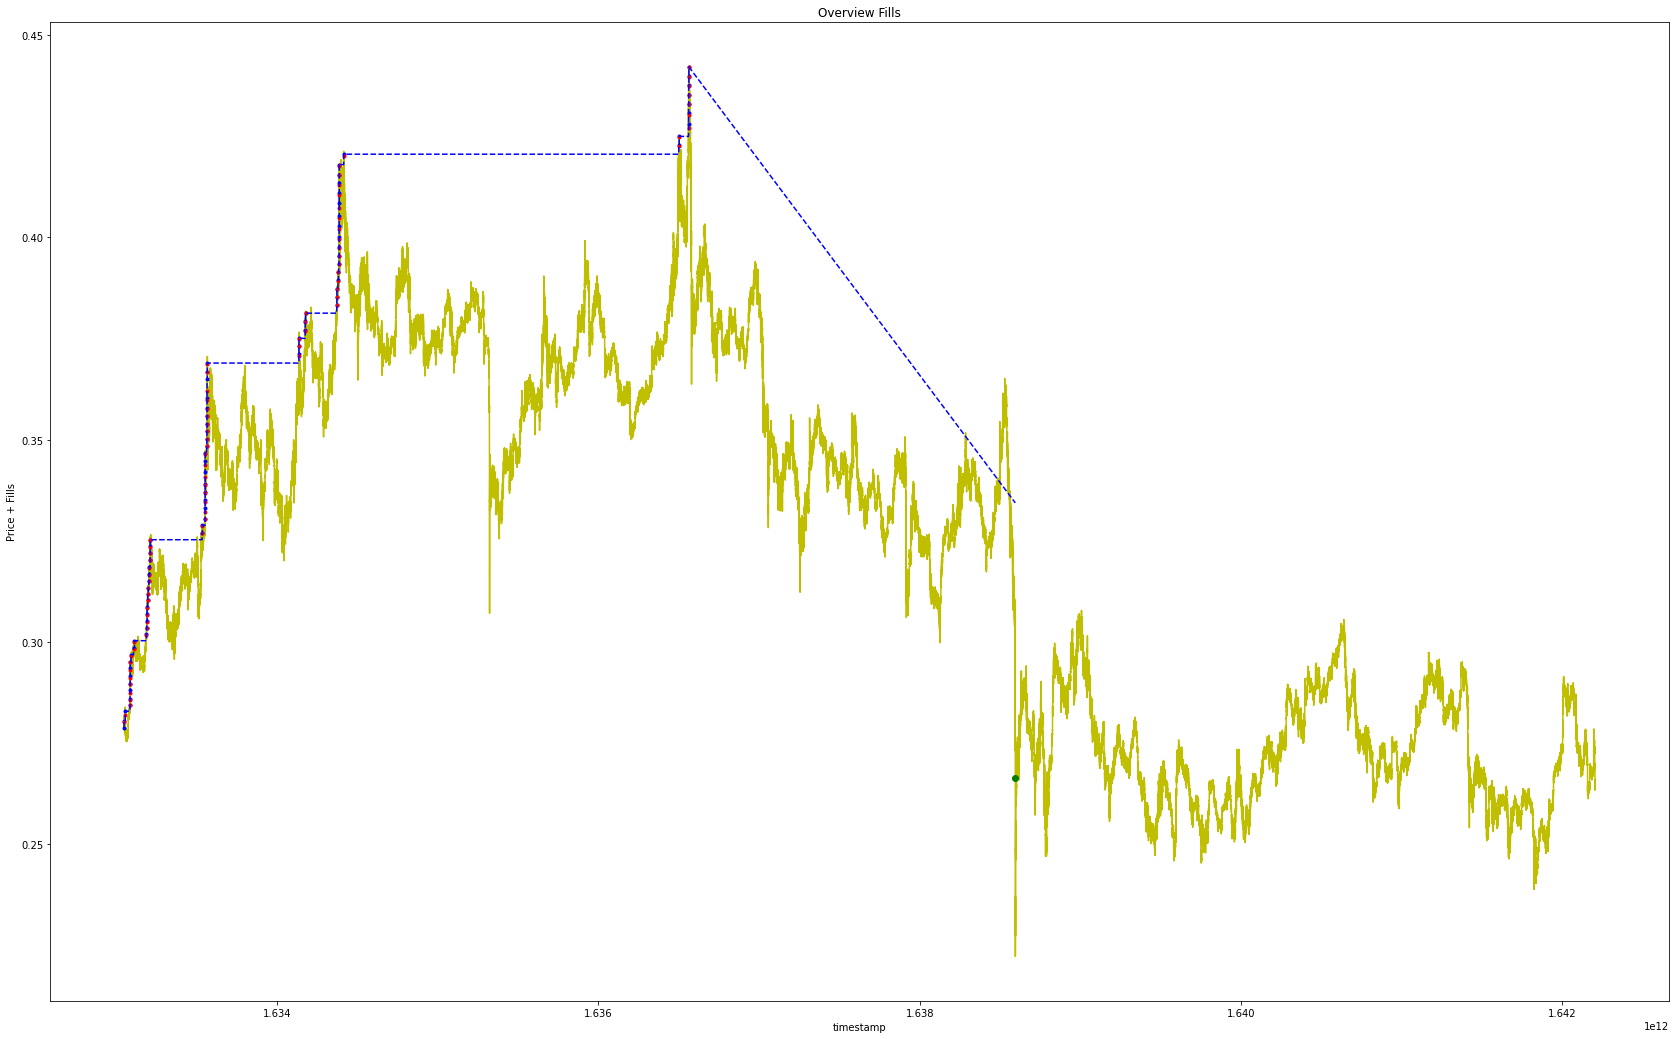

In [46]:
plot_fills(df, fdf, plot_whole_df=True,title="Overview Fills")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Short Position size'>

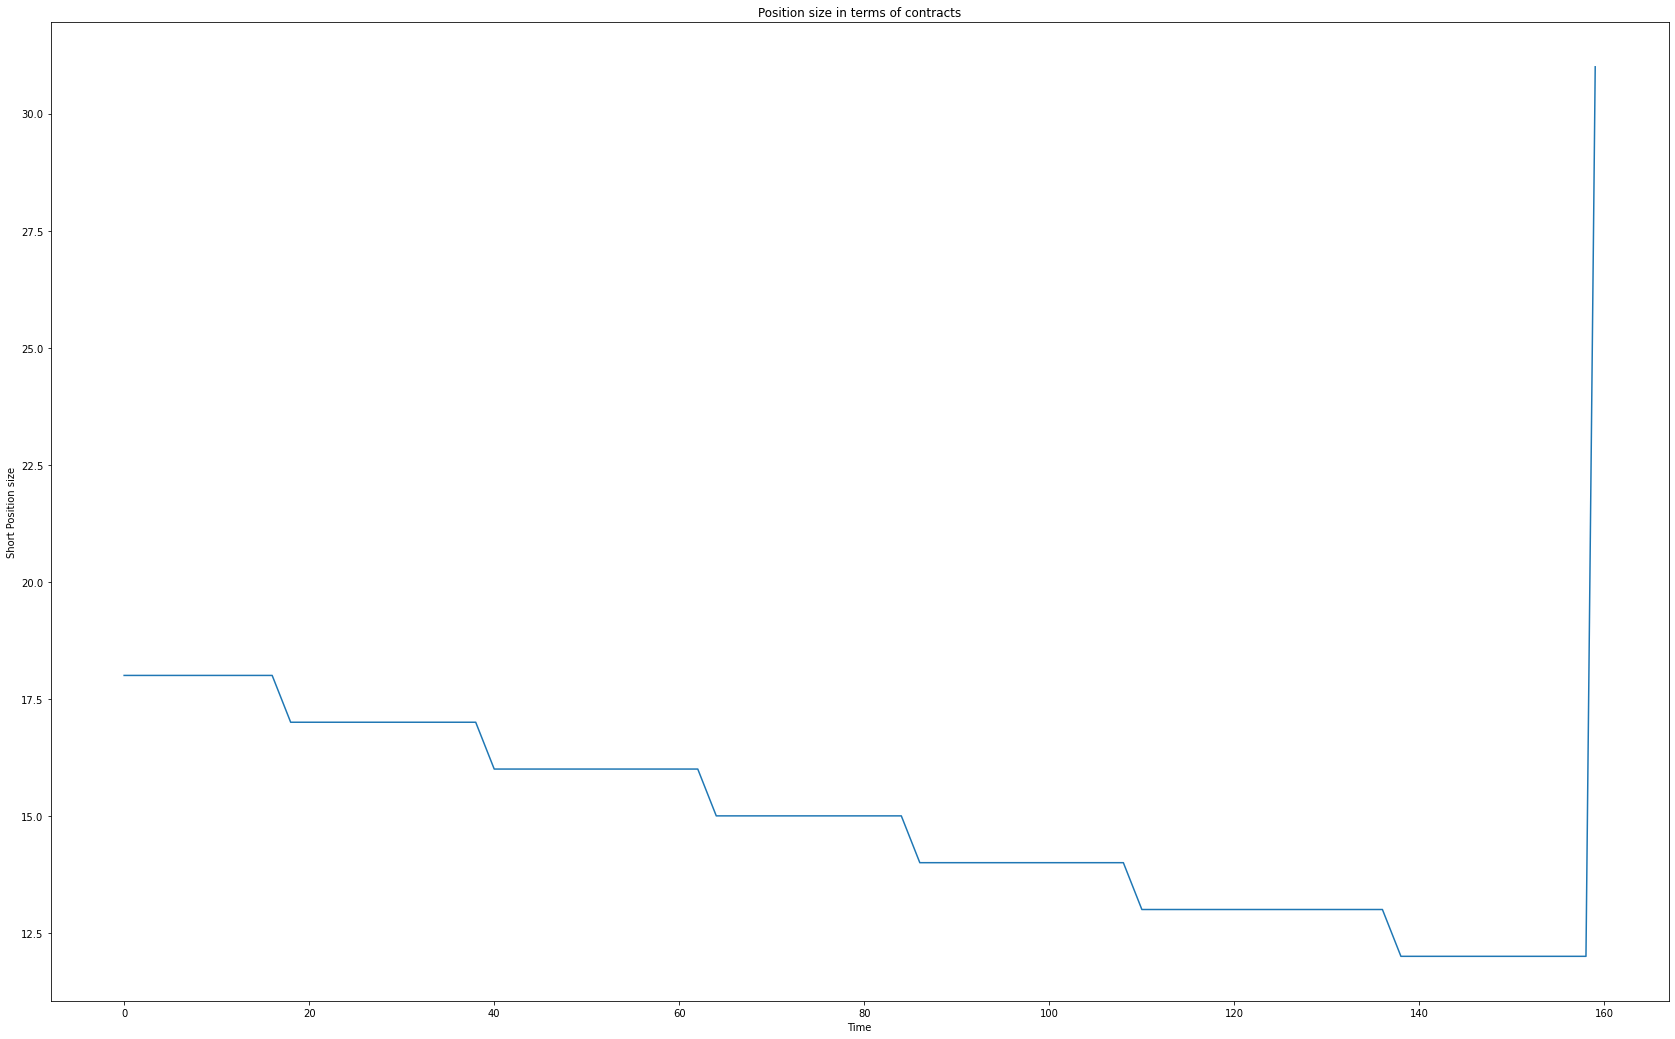

In [47]:
fdf[fdf.psize > 0.0].psize.plot(title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size")
fdf[fdf.psize < 0.0].psize.plot(title="Position size in terms of contracts", xlabel="Time", ylabel="Short Position size")

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

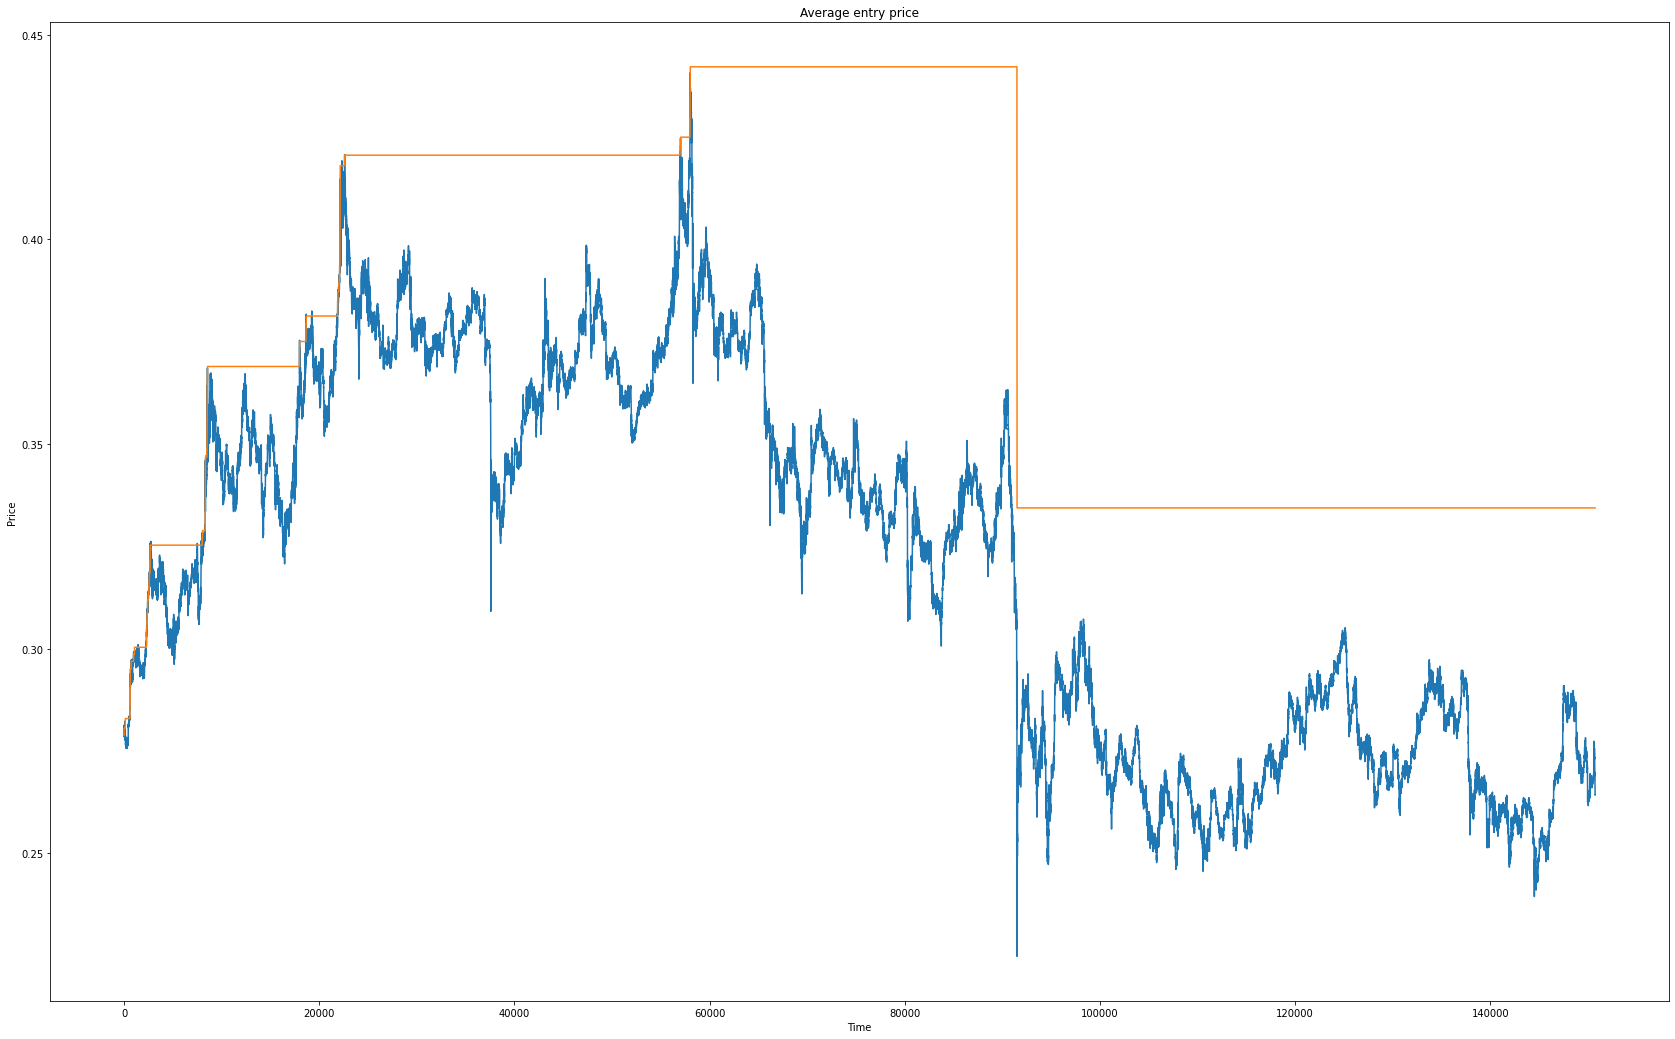

In [48]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf.long_pprice.replace(0.0, np.nan).plot()
sdf.shrt_pprice.replace(0.0, np.nan).plot()

Mean price action distance long 0.189444


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

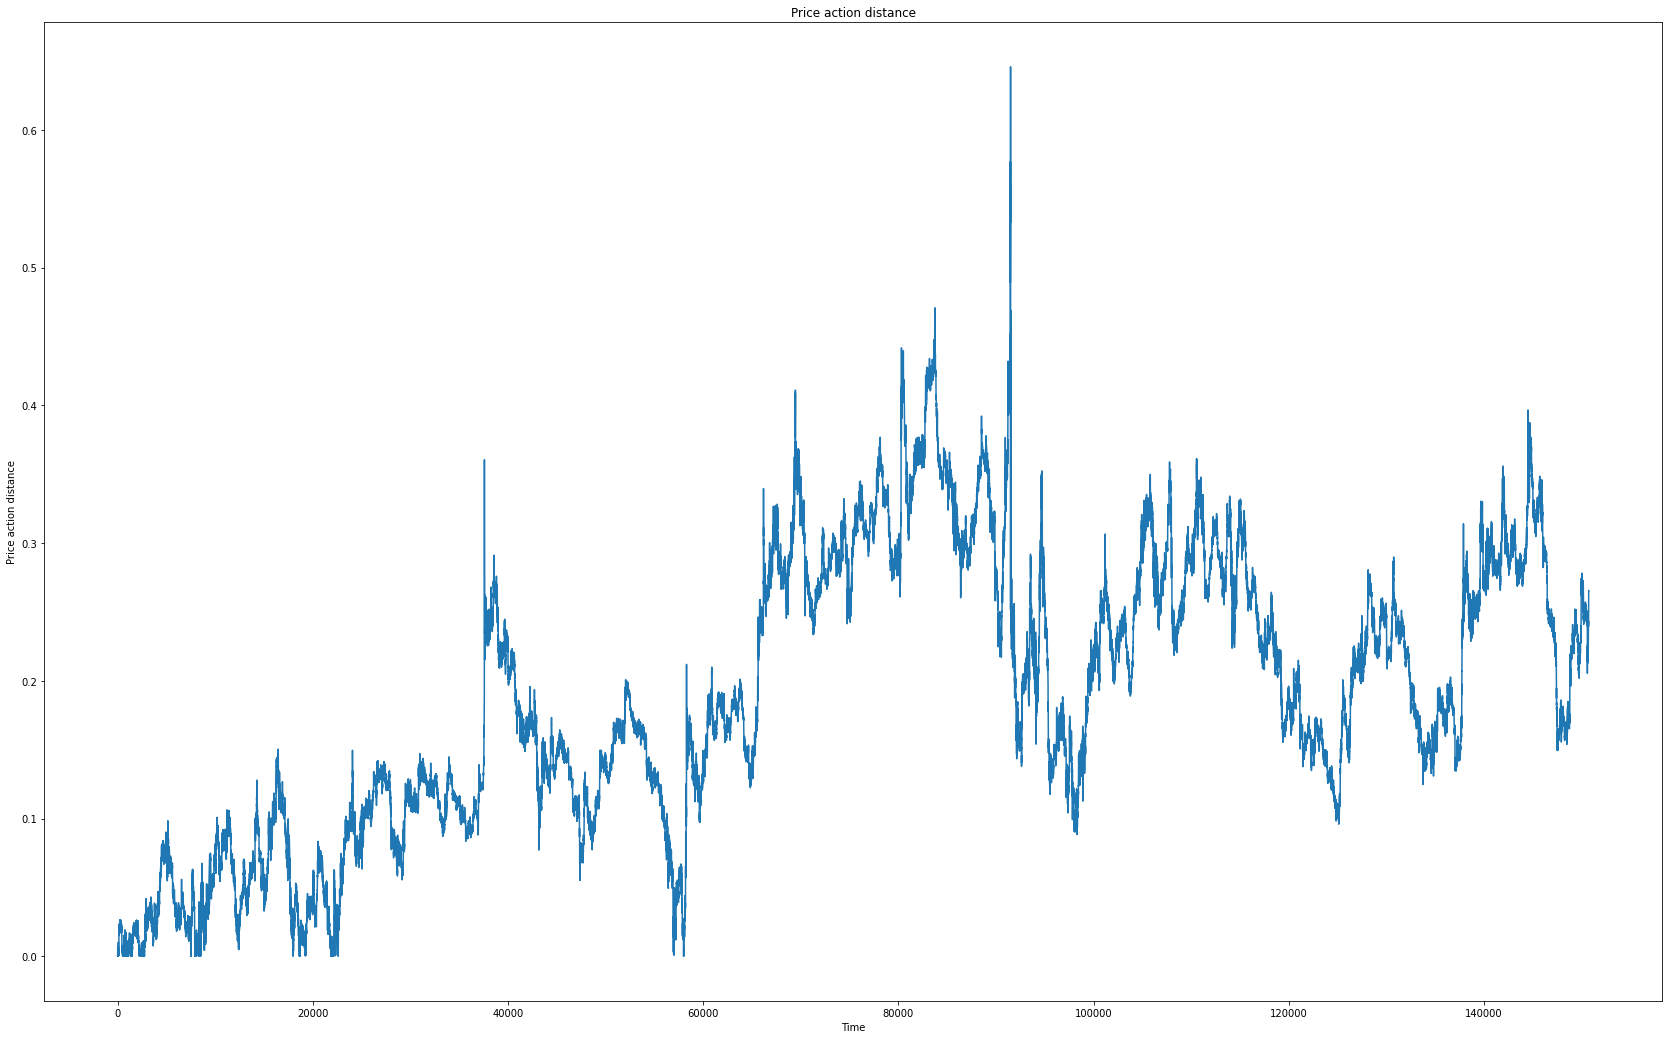

In [49]:
lpprices = sdf[sdf.long_pprice != 0.0]
pa_distance_long = (lpprices.long_pprice - lpprices.price).abs() / lpprices.price
print(f"Mean price action distance long {pa_distance_long.mean():.6f}")
pa_distance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short nan


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

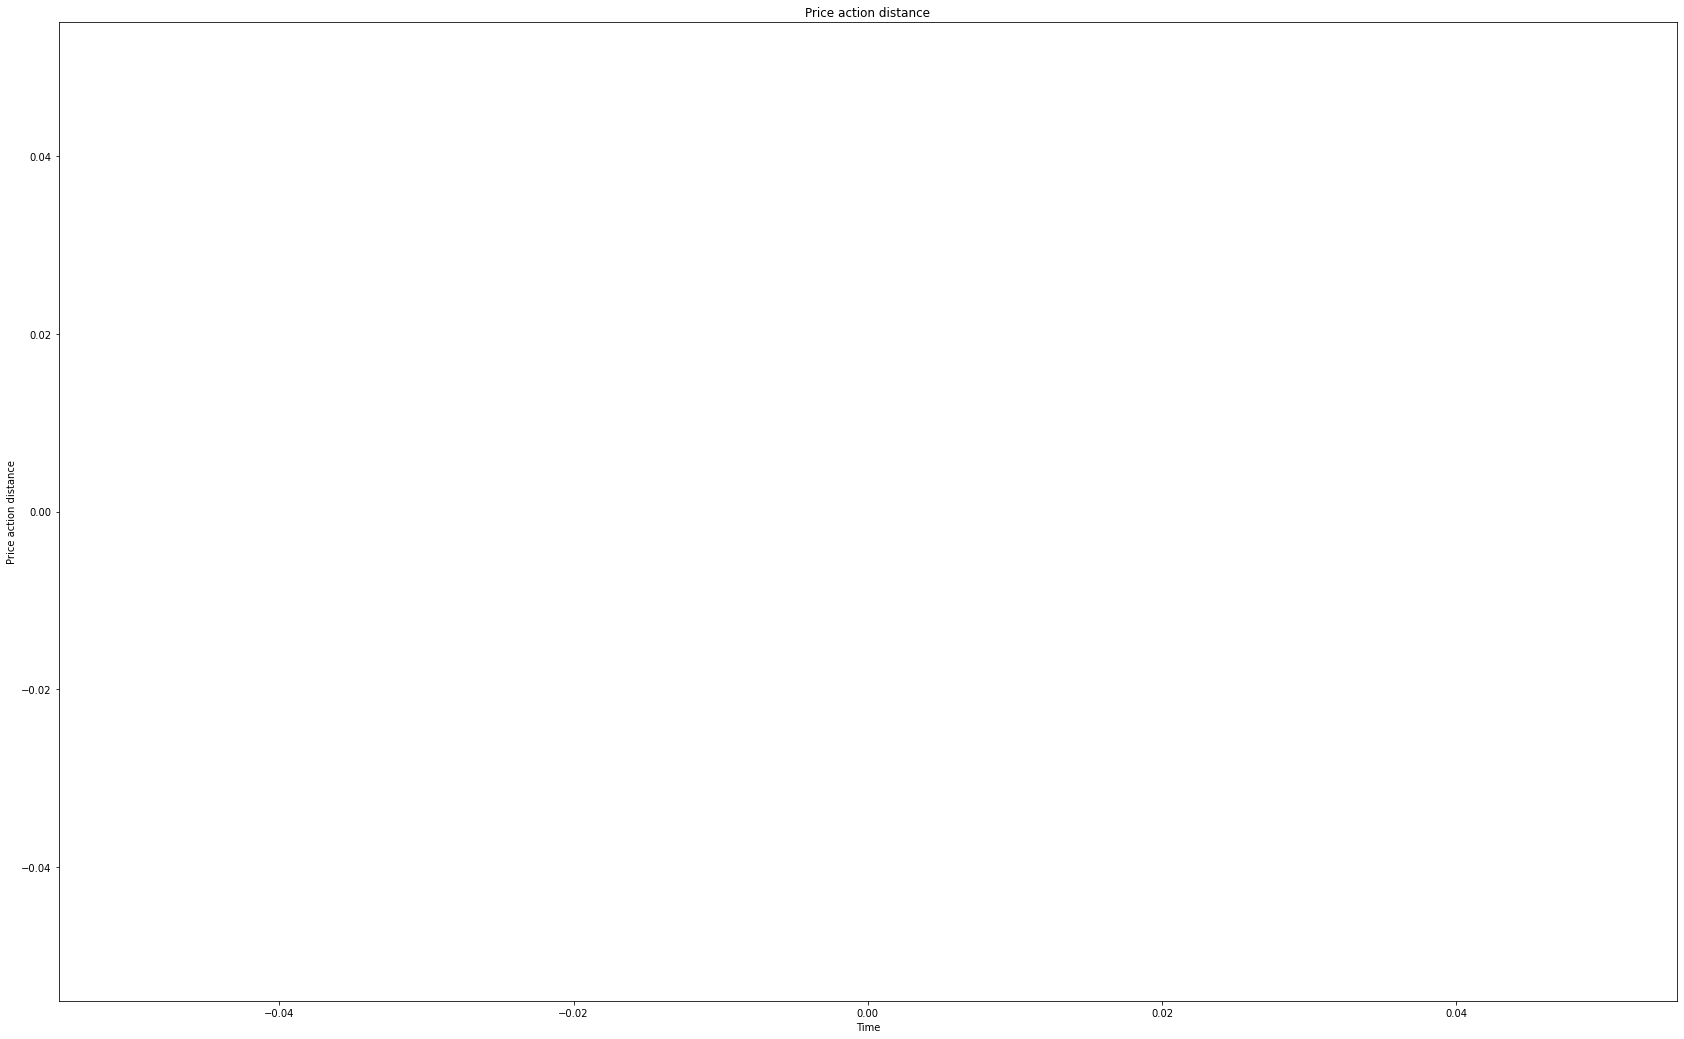

In [50]:
spprices = sdf[sdf.shrt_pprice != 0.0]
pa_distance_shrt = (spprices.shrt_pprice - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {pa_distance_shrt.mean():.6f}")
pa_distance_shrt.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

,qty,price,psize,pprice,pbr,eprice_pprice_diff,ddown_factor,bkr_price
0,19.0,0.26402,19.0,0.2640200000,0.1003276,0.0000000000,NaN,0.0
1,38.0,0.13201,57.0,0.1760133333,0.2006552,0.3333333333,2.0,0.0


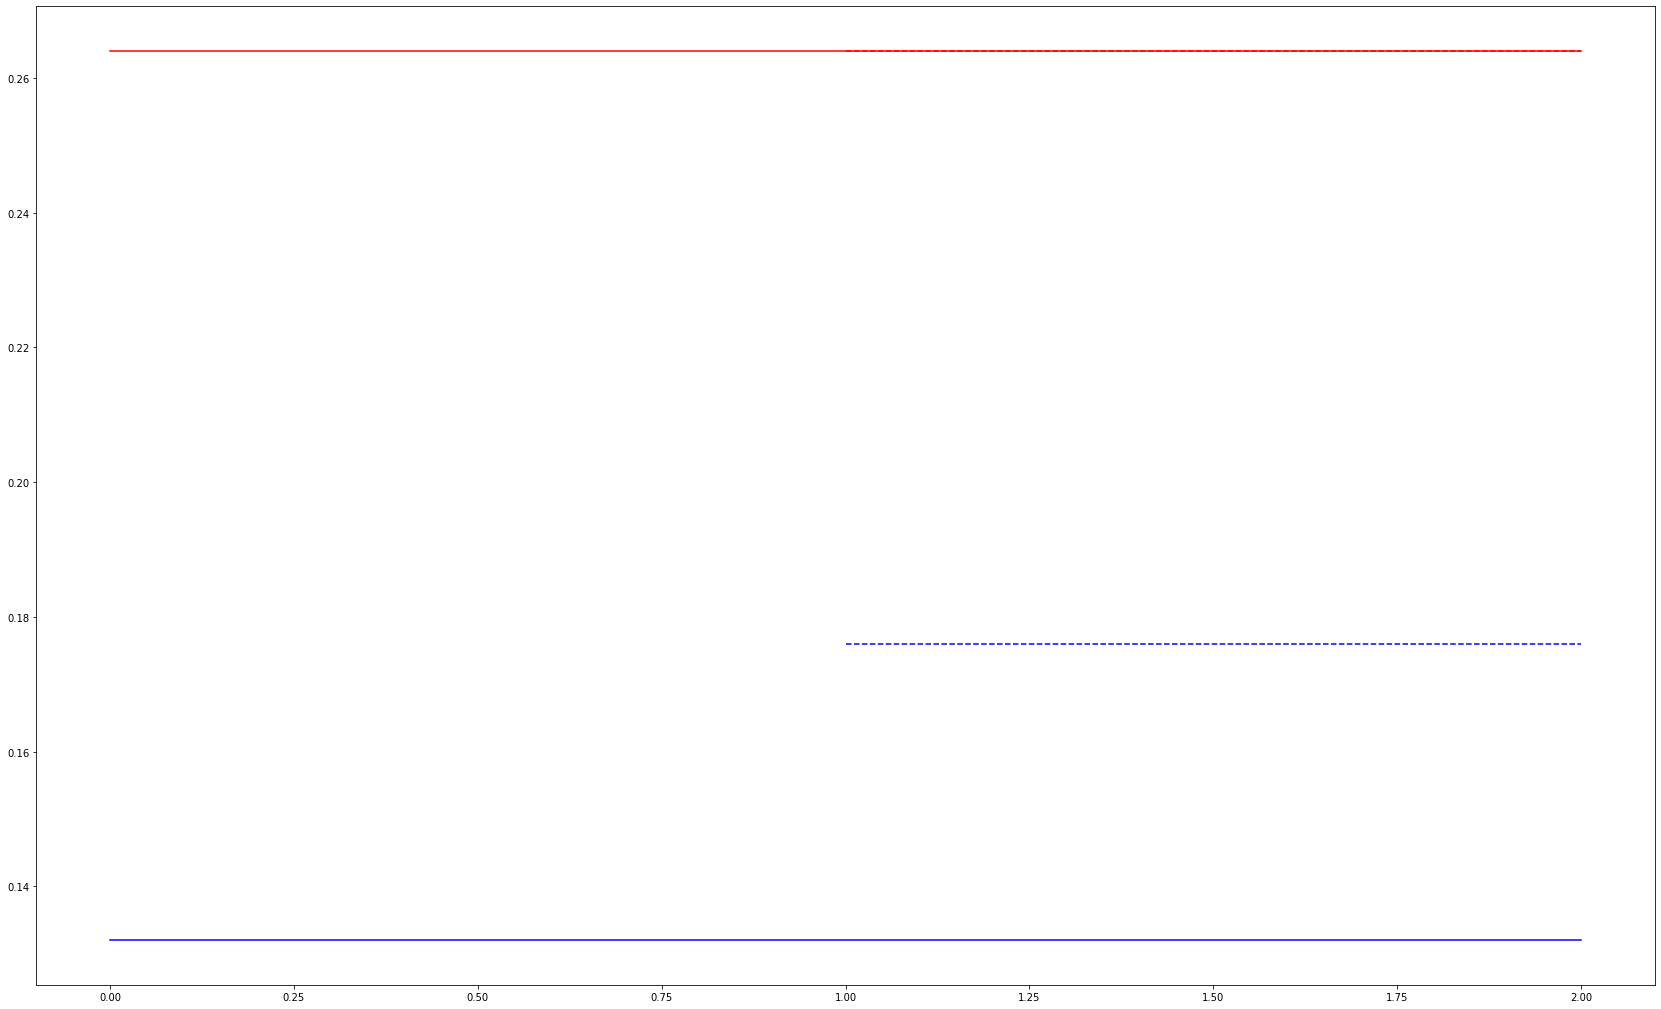

In [40]:
balance = config_to_test['starting_balance']
highest_bid = df.price.iloc[-1]

inverse = config_to_test['inverse']
do_long = True
qty_step = config_to_test['qty_step']
price_step = config_to_test['price_step']
min_qty = config_to_test['min_qty']
min_cost = config_to_test['min_cost']
c_mult = config_to_test['c_mult']

grid_span = config_to_test['long']['grid_span']
pbr_limit = config_to_test['long']['pbr_limit']
max_n_entry_orders = config_to_test['long']['max_n_entry_orders']
initial_qty_pct = config_to_test['long']['initial_qty_pct']
eprice_pprice_diff = config_to_test['long']['eprice_pprice_diff']
eprice_exp_base = config_to_test['long']['eprice_exp_base']
secondary_pbr_allocation = config_to_test['long']['secondary_pbr_allocation']
secondary_pprice_diff = config_to_test['long']['secondary_pprice_diff']

grid = calc_whole_long_entry_grid(
    balance, highest_bid, inverse, qty_step, price_step, min_qty, min_cost,
    c_mult, grid_span, pbr_limit, max_n_entry_orders, initial_qty_pct,
    eprice_pprice_diff, secondary_pbr_allocation, secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base)
gdf = pd.DataFrame(grid, columns=['qty', 'price', 'psize', 'pprice', 'pbr'])
    
gdf.loc[:, 'eprice_pprice_diff'] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:,'ddown_factor'] = gdf.qty / gdf.psize.shift()
gdf.loc[:,'bkr_price'] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult), axis=1)
colors = 'rbygcmk'
for i, e in enumerate(gdf.itertuples()):
    plt.plot([0, 2], [e.price, e.price], f'{colors[i%len(colors)]}-')
    plt.plot([1, 2], [e.pprice, e.pprice], f'{colors[i%len(colors)]}--')
gdf

,qty,price,psize,pprice,pbr,eprice_pprice_diff,ddown_factor,bkr_price
0,-19.0,0.26402,-19.0,0.2640200000,0.1003276,0.0000000000,NaN,2.8955989474
1,-21.0,0.26699,-40.0,0.2655792500,0.2124634,0.0052839058,1.1052631579,1.5155792500
2,-52.0,0.27195,-92.0,0.2691801087,0.4952914,0.0101852962,1.3000000000,0.8126583696


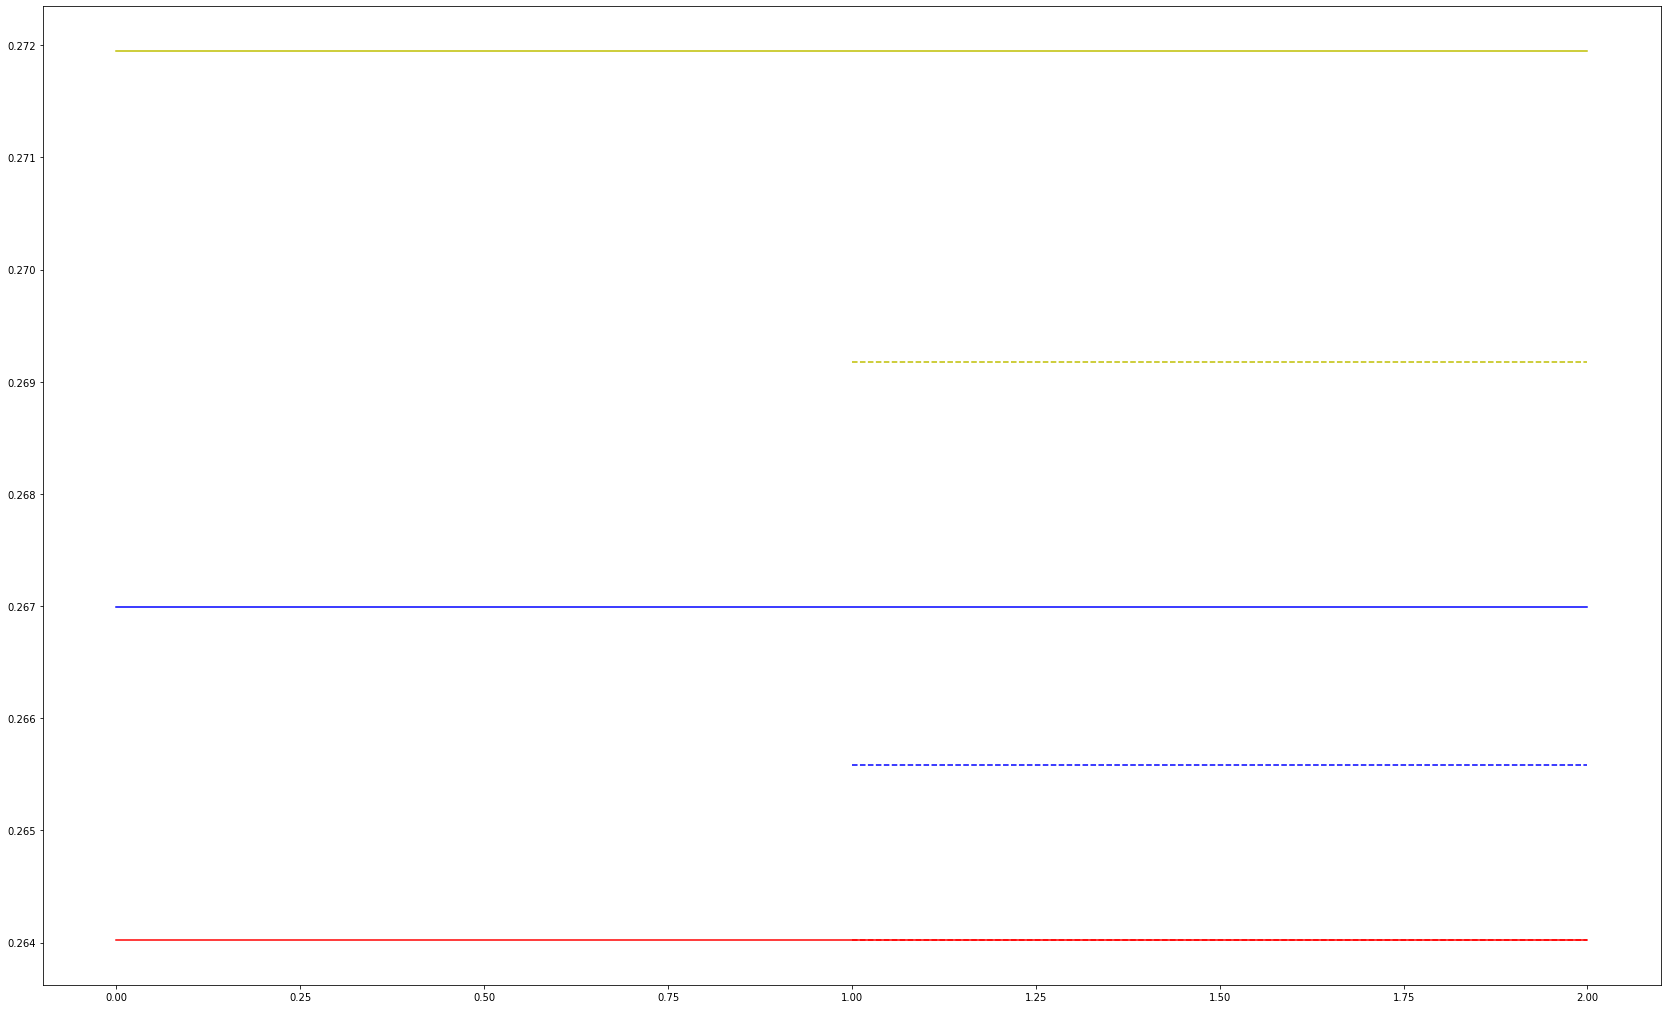

In [41]:
balance = config_to_test['starting_balance']
lowest_ask = df.price.iloc[-1]

inverse = config_to_test['inverse']
do_shrt = True
qty_step = config_to_test['qty_step']
price_step = config_to_test['price_step']
min_qty = config_to_test['min_qty']
min_cost = config_to_test['min_cost']
c_mult = config_to_test['c_mult']

grid_span = config_to_test['shrt']['grid_span']
pbr_limit = config_to_test['shrt']['pbr_limit']
max_n_entry_orders = config_to_test['shrt']['max_n_entry_orders']
initial_qty_pct = config_to_test['shrt']['initial_qty_pct']
eprice_pprice_diff = config_to_test['shrt']['eprice_pprice_diff']
eprice_exp_base = config_to_test['shrt']['eprice_exp_base']
secondary_pbr_allocation = config_to_test['shrt']['secondary_pbr_allocation']
secondary_pprice_diff = config_to_test['shrt']['secondary_pprice_diff']

grid = calc_whole_shrt_entry_grid(
    balance, highest_bid, inverse, qty_step, price_step, min_qty, min_cost,
    c_mult, grid_span, pbr_limit, max_n_entry_orders, initial_qty_pct,
    eprice_pprice_diff, secondary_pbr_allocation, secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base)
gdf = pd.DataFrame(grid, columns=['qty', 'price', 'psize', 'pprice', 'pbr'])
    
gdf.loc[:, 'eprice_pprice_diff'] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:,'ddown_factor'] = gdf.qty / gdf.psize.shift()
gdf.loc[:,'bkr_price'] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult), axis=1)
colors = 'rbygcmk'
for i, e in enumerate(gdf.itertuples()):
    plt.plot([0, 2], [e.price, e.price], f'{colors[i%len(colors)]}-')
    plt.plot([1, 2], [e.pprice, e.pprice], f'{colors[i%len(colors)]}--')
gdf